In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Notebook description

Notebook to make preliminary plots of the HFSE abundaces measured in the CV chondrites. The notebook uses two seperate datasets collected in 2019 and 2022. All of the data was collected using the LA-ICP-MS at Rutgers University. The meteorites analyzed include:
- Vigps1B
- Vigps2B
- Leops2B
- Alps1
- Alps6
- Alps9

# Read in data

## 2022 data

In [2]:
data_2022 = pd.read_csv('2022_June_SQ_input2.csv')
data_2022

,Total_Order,Run_Order,Run_Date,Year,LA_Name,Met_Name,Met_Type,Object,Map_region,Spot_Num,...,Pb206_ppm_2SE(int),Pb206_ppm_2SD,Th232_ppm_mean,Th232_ppm_median,Th232_ppm_2SE(int),Th232_ppm_2SD,U238_ppm_mean,U238_ppm_median,U238_ppm_2SE(int),U238_ppm_2SD
0,1,1.0,6/22/22,2022,BIR-25,BIR,standard,NaN,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2.0,6/22/22,2022,BIR-25,BIR,standard,NaN,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,3.0,6/22/22,2022,BIR-25,BIR,standard,NaN,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,4.0,6/22/22,2022,Vigps1B_c14_9,Vigps1B,CV,c14,NaN,9,...,0.067496,0.527162,NaN,NaN,NaN,NaN,0.003396,-8.940000e-12,0.006508,0.050828
4,5,5.0,6/22/22,2022,Vigps1B_c14_10,Vigps1B,CV,c14,NaN,10,...,0.074675,0.578430,NaN,NaN,NaN,NaN,0.047421,2.620000e-12,0.024658,0.191000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,411,258.0,6/29/22,2022,Alps6_c5_1,Alps6,CV,c5,NaN,1,...,0.003734,0.028188,0.001339,0.000000,0.000947,0.007148,0.000000,0.000000e+00,0.000000,0.000000
408,412,259.0,6/29/22,2022,BCR-65,BCR,check_standard,NaN,NaN,2,...,0.432777,3.380094,7.437679,7.175756,0.194233,1.517005,3.189052,3.139050e+00,0.098848,0.772026
409,413,260.0,6/29/22,2022,BIR-65,BIR,standard,NaN,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
410,414,261.0,6/29/22,2022,BIR-65,BIR,standard,NaN,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2019 data

In [3]:
data_2019 = pd.read_csv('2019_LA_CVdata_SQ_input.csv')
data_2019

,Run_Order,Run_Date,Year,Book_num,Book_Order_rawdata,LA_Name,Met_Name,Met_Type,Object,Spot_Num,...,Re185_ppm_2SE(int),Re185_ppm_2SD,Th232_ppm_mean,Th232_ppm_median,Th232_ppm_2SE(int),Th232_ppm_2SD,U238_ppm_mean,U238_ppm_median,U238_ppm_2SE(int),U238_ppm_2SD
0,1,7/18/19,2019,1,newlines_1,614,614,standard,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,7/18/19,2019,1,newlines_2,612,612,standard,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,7/18/19,2019,1,newlines_3,610,610,standard,NaN,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,7/18/19,2019,1,newlines_4,BHVO,BHVO,check_standard,NaN,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,7/18/19,2019,1,newlines_5,BIR,BIR,standard,NaN,1,...,0.0,0.0,0.028000,0.000002,0.008883,0.109156,0.031991,1.120000e-07,0.010450,0.128406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,233,7/18/19,2019,13,85micron_15,BIR,BIR,standard,NaN,1,...,0.0,0.0,0.027998,0.031472,0.007421,0.058902,0.031979,3.864216e-02,0.009526,0.075612
233,234,7/18/19,2019,13,85micron_16,BCR,BCR,check_standard,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
234,235,7/18/19,2019,13,85micron_17,614,614,standard,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235,236,7/18/19,2019,13,85micron_18,612,612,standard,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data finder function

In [6]:
def sub_df(pd_df, meteorite='all', obj='all', spots='all', phase='all', element='all', dtype='mean', array='off'):
    
    #note:
    # - can only grab one object
    # - can only grab one phase
    
    if (meteorite != 'all'):
        df = pd_df[pd_df.Met_Name == meteorite]
        
        if obj!='all' and spots=='all':
            df = pd_df[(pd_df.Met_Name == meteorite) & (pd_df.Object == obj)]
            
        if obj!='all' and spots!='all':
            
            df = pd_df[(pd_df.Met_Name == meteorite) & (pd_df.Object == obj) & (pd_df.Spot_Num == spots[0])]
            if len(spots) > 1:
                for i in range(1, len(spots)):
                    df_spot = pd_df[(pd_df.Met_Name == meteorite) & (pd_df.Object == obj) & (pd_df.Spot_Num == spots[i])]
                    df = pd.concat([df, df_spot])
    
    if (meteorite=='all'): 
        df = pd_df
                    
    if (phase != 'all'):
        df = df[df.Phase==phase[0]]
        
    if (element!='all'):
        col_names = df.columns.values
        col_grab  = ['LA_Name']
        if array == 'on':
            col_grab = []
        
        if element =='REE':
            element = ['La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu']
        
        if element == 'HFSE':
            element = ['Zr', 'Hf', 'Nb', 'Ta']
            
        if element == 'Zr/Hf':
            data_names = df['LA_Name']
            
            for x in col_names:
                if ('Zr' in x) and ('ppm' in x) and (dtype in x):
                    zr = x
                if ('Hf' in x) and ('ppm' in x) and (dtype in x):
                    hf = x
                
            df       = df[[zr, hf]]
            df[df<0] = np.nan
            df['Zr/Hf'] = df.apply(lambda row: row[-2]/row[-1], axis=1)
            df = df.merge(data_names, left_index=True, right_index=True)
            df = df.set_index(['LA_Name'])
            
            if array=='on':
                df = df['Zr/Hf']
            
        if element == 'Nb/Ta':
            data_names = df['LA_Name']
            
            for x in col_names:
                if ('Nb' in x) and ('ppm' in x) and (dtype in x):
                    nb = x
                if ('Ta' in x) and ('ppm' in x) and (dtype in x):
                    ta = x
                
            df       = df[[nb, ta]]
            df[df<0] = np.nan
            df['Nb/Ta'] = df.apply(lambda row: row[-2]/row[-1], axis=1)
            df = df.merge(data_names, left_index=True, right_index=True)
            df = df.set_index(['LA_Name'])
            
            if array=='on':
                df = df['Nb/Ta']
        
        if element != 'Zr/Hf' and element != 'Nb/Ta':
            
            for i in range(0, len(element)):
                for x in col_names:
                    if (element[i] in x) and ('ppm' in x) and (dtype in x):
                        col_grab = np.append(col_grab, x)
                    
                 
                    
            df = df[col_grab]
            if array == 'on':
                df[df<0]= np.nan
        
            
        
        
    return df

In [8]:
sub_df(data_2022, meteorite='Alps9', obj='c20', phase=['olv'], element='Nb/Ta')

,Nb93_ppm_mean,Ta181_ppm_mean,Nb/Ta
LA_Name,,,
Alps9_c20_1,0.031082,0.002528,12.292697
Alps9_c20_4,0.009332,NaN,NaN


# Plotting Zr/Hf vs Nb/Ta, first test for alps1

### plotting Zr/Hf vs Nb/Ta by phase

Let's see what phases are present in this meteorite. the data for alps1 was only aqquired in 2019, fyi.

In [6]:
data_2019_alps1 = sub_df(data_2019, meteorite='Alps1')
data_2019_alps1['Phase'].unique()

array(['olv', 'opx', 'gls', 'cpx', 'aoa', 'matrix'], dtype=object)

So it looks like we'll have 6 different groups to plot.

In [20]:
#first I'll grab the data for the six phases

#Olivine
olv_2019 = sub_df(data_2019, meteorite='Vigps2B', phase=['olv'], element=['Zr', 'Hf', 'Nb', 'Ta']).set_index('LA_Name')
olv_2019[olv_2019<0] = np.nan
olv_2019['Zr/Hf'] =  olv_2019.apply(lambda row: row[-4]/row[-3], axis = 1)
olv_2019['Nb/Ta'] =  olv_2019.apply(lambda row: row[-3]/row[-2], axis = 1)

#Ortho-pyroxene
opx_2019 = sub_df(data_2019, meteorite='Vigps2B', phase=['opx'], element=['Zr', 'Hf', 'Nb', 'Ta']).set_index('LA_Name')
opx_2019[opx_2019<0] = np.nan
opx_2019['Zr/Hf'] =  opx_2019.apply(lambda row: row[-4]/row[-3], axis = 1)
opx_2019['Nb/Ta'] =  opx_2019.apply(lambda row: row[-3]/row[-2], axis = 1)

#Glass
gls_2019 = sub_df(data_2019, meteorite='Vigps2B', phase=['gls'], element=['Zr', 'Hf', 'Nb', 'Ta']).set_index('LA_Name')
gls_2019[gls_2019<0] = np.nan
gls_2019['Zr/Hf'] =  gls_2019.apply(lambda row: row[-4]/row[-3], axis = 1)
gls_2019['Nb/Ta'] =  gls_2019.apply(lambda row: row[-3]/row[-2], axis = 1)

#Clino-pyroxene
cpx_2019 = sub_df(data_2019, meteorite='Vigps2B', phase=['cpx'], element=['Zr', 'Hf', 'Nb', 'Ta']).set_index('LA_Name')
cpx_2019[cpx_2019<0] = np.nan
cpx_2019['Zr/Hf'] =  cpx_2019.apply(lambda row: row[-2]/row[-1], axis = 1)
cpx_2019['Nb/Ta'] =  cpx_2019.apply(lambda row: row[-3]/row[-2], axis = 1)

#AOA
aoa_2019 = sub_df(data_2019, meteorite='Vigps2B', phase=['aoa'], element=['Zr', 'Hf', 'Nb', 'Ta']).set_index('LA_Name')
aoa_2019[aoa_2019<0] = np.nan
aoa_2019['Zr/Hf'] =  aoa_2019.apply(lambda row: row[-4]/row[-3], axis = 1)
aoa_2019['Nb/Ta'] =  cpx_2019.apply(lambda row: row[-3]/row[-2], axis = 1)

#Matrix
mtx_2019 = sub_df(data_2019, meteorite='Vigps2B', phase=['matrix'], element=['Zr', 'Hf', 'Nb', 'Ta']).set_index('LA_Name')
mtx_2019[mtx_2019<0] = np.nan
mtx_2019['Zr/Hf'] =  mtx_2019.apply(lambda row: row[-4]/row[-3], axis = 1)
mtx_2019['Nb/Ta'] =  mtx_2019.apply(lambda row: row[-3]/row[-2], axis = 1)

''

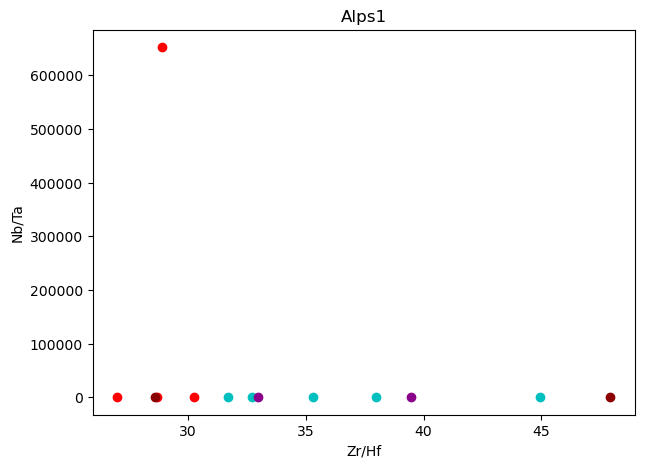

In [21]:
#setting up plot
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_xlabel('Zr/Hf')
ax.set_ylabel('Nb/Ta')

#plotting
ax.scatter(olv_2019['Zr/Hf'], olv_2019['Nb/Ta'], color='red', label='olv')
ax.scatter(opx_2019['Zr/Hf'], opx_2019['Nb/Ta'], color='darkred', label='opx')
ax.scatter(gls_2019['Zr/Hf'], gls_2019['Nb/Ta'], color='c', label='gls')
ax.scatter(cpx_2019['Zr/Hf'], cpx_2019['Nb/Ta'], color='yellowgreen', label='cpx')
ax.scatter(aoa_2019['Zr/Hf'], aoa_2019['Nb/Ta'], color='sienna', label='aoa')
ax.scatter(mtx_2019['Zr/Hf'], mtx_2019['Nb/Ta'], color='darkmagenta', label='matrix')

#further formating
ax.set_title('Alps1')
#ax.set_ylim([0, 40])
;

# plotting all the data with improved function

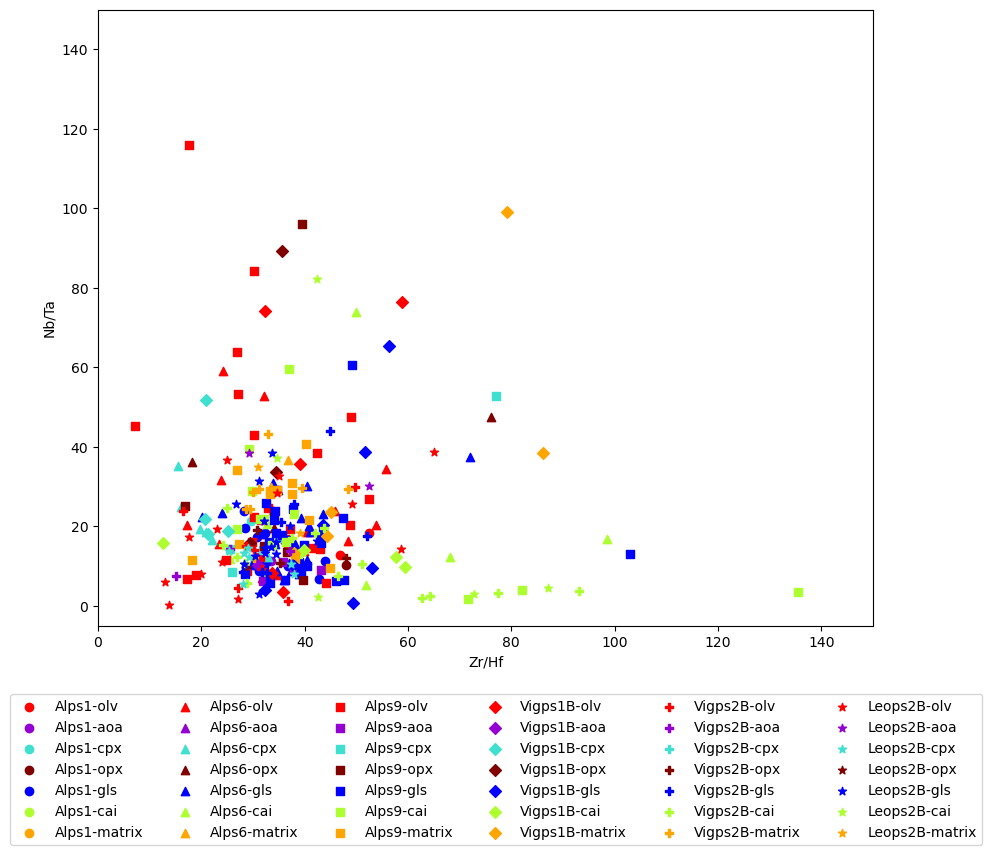

In [38]:
#plotting

#what I want to look at:
meteorites = ['Alps1', 'Alps6', 'Alps9', 'Vigps1B', 'Vigps2B', 'Leops2B']
phases     = ['olv', 'aoa', 'cpx', 'opx', 'gls', 'cai', 'matrix']

#arrays for plotting
met_shape = ['o', '^', 's', 'D', 'P', '*']
phs_color = ['red', 'darkviolet', 'turquoise', 'maroon', 'blue', 'greenyellow', 'orange']

#setting up plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xlabel('Zr/Hf')
ax.set_ylabel('Nb/Ta')
ax.set_xlim([0, 150])
ax.set_ylim([-5, 150])

#plotting loop
met_i = 0
for met in meteorites:
    phs_i = 0
    for phs in phases:
        
        #grabbing data
        d2019_zrhf = sub_df(data_2019, meteorite=met, phase=[phs], element='Zr/Hf', array='on')
        d2019_nbta = sub_df(data_2019, meteorite=met, phase=[phs], element='Nb/Ta', array='on')
        
        d2022_zrhf = sub_df(data_2022, meteorite=met, phase=[phs], element='Zr/Hf', array='on')
        d2022_nbta = sub_df(data_2022, meteorite=met, phase=[phs], element='Nb/Ta', array='on')
        
        #plotting
        ax.scatter(d2019_zrhf, d2019_nbta, color=phs_color[phs_i], marker=met_shape[met_i], label=met+'-'+phs)
        ax.scatter(d2022_zrhf, d2022_nbta, color=phs_color[phs_i], marker=met_shape[met_i])
        
        phs_i+=1
    met_i+=1
    
ax.legend(bbox_to_anchor=(1.15, -0.1), ncols=6);

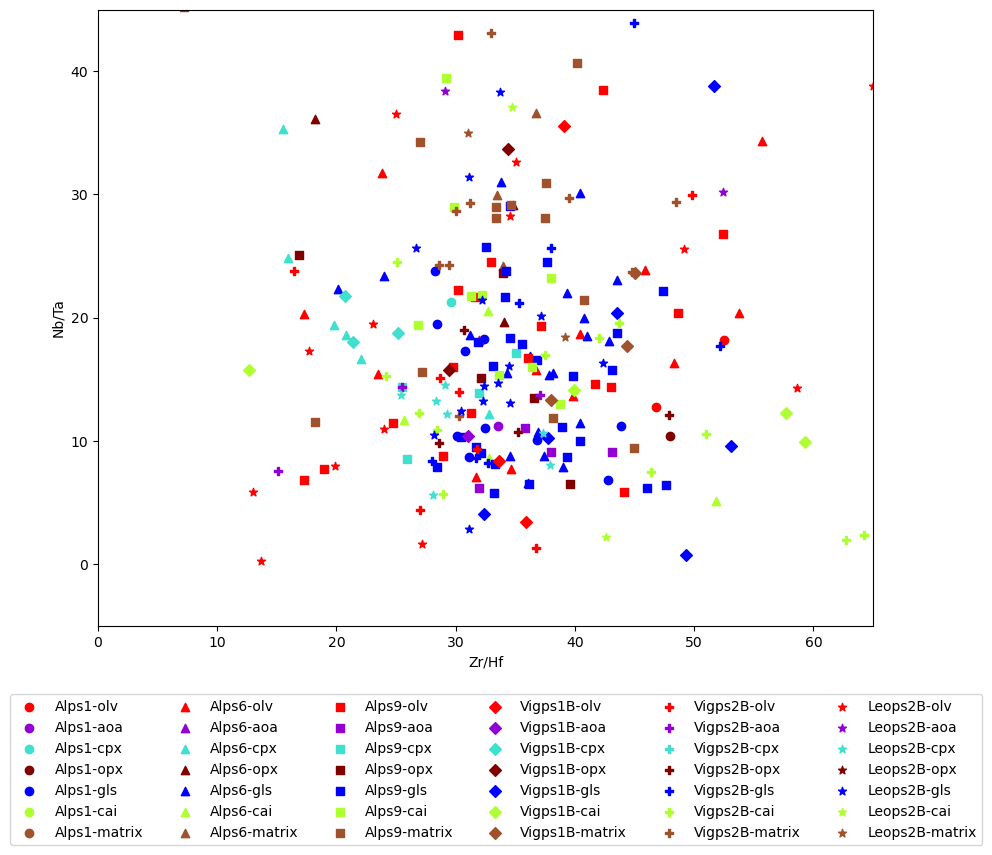

In [37]:
#plotting

#what I want to look at:
meteorites = ['Alps1', 'Alps6', 'Alps9', 'Vigps1B', 'Vigps2B', 'Leops2B']
phases     = ['olv', 'aoa', 'cpx', 'opx', 'gls', 'cai', 'matrix']

#arrays for plotting
met_shape = ['o', '^', 's', 'D', 'P', '*']
phs_color = ['red', 'darkviolet', 'turquoise', 'maroon', 'blue', 'greenyellow', 'sienna']

#setting up plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xlabel('Zr/Hf')
ax.set_ylabel('Nb/Ta')
ax.set_xlim([0, 65])
ax.set_ylim([-5, 45])

#plotting loop
met_i = 0
for met in meteorites:
    phs_i = 0
    for phs in phases:
        
        #grabbing data
        d2019_zrhf = sub_df(data_2019, meteorite=met, phase=[phs], element='Zr/Hf', array='on')
        d2019_nbta = sub_df(data_2019, meteorite=met, phase=[phs], element='Nb/Ta', array='on')
        
        d2022_zrhf = sub_df(data_2022, meteorite=met, phase=[phs], element='Zr/Hf', array='on')
        d2022_nbta = sub_df(data_2022, meteorite=met, phase=[phs], element='Nb/Ta', array='on')
        
        #plotting
        ax.scatter(d2019_zrhf, d2019_nbta, color=phs_color[phs_i], marker=met_shape[met_i], label=met+'-'+phs)
        ax.scatter(d2022_zrhf, d2022_nbta, color=phs_color[phs_i], marker=met_shape[met_i])
        
        phs_i+=1
    met_i+=1
    
ax.legend(bbox_to_anchor=(1.15, -0.1), ncols=6);

# Marina's import code

In [ ]:
#import 2019 data
CV2019_SQ = pd.read_csv('/Users/Marina/Desktop/CV_REE_working/LA_ICPMS_data/2019_Rutgers/2019_python_input/2019_LA_CVdata_SQ_input.csv',index_col=None)
CV2019_SQ = CV2019_SQ.fillna(np.nan)
CV2019_SQ.Spot_Size = CV2019_SQ.Spot_Size.astype(int)
CV2019_SQ.Spot_Num = CV2019_SQ.Spot_Num.astype(int)
CV2019_SQ.Standard_Spot_Size = CV2019_SQ.Standard_Spot_Size.astype(int)

CV2019_Si = pd.read_csv('/Users/Marina/Desktop/CV_REE_working/LA_ICPMS_data/2019_Rutgers/2019_python_input/2019_LA_CVdata_Si_input.csv',index_col=None)
CV2019_Si = CV2019_Si.fillna(np.nan)
CV2019_Si.Spot_Size = CV2019_Si.Spot_Size.astype(int)
CV2019_Si.Spot_Num = CV2019_Si.Spot_Num.astype(int)
CV2019_Si.Standard_Spot_Size = CV2019_Si.Standard_Spot_Size.astype(int)

CV2019_Mg = pd.read_csv('/Users/Marina/Desktop/CV_REE_working/LA_ICPMS_data/2019_Rutgers/2019_python_input/2019_LA_CVdata_Mg_input.csv',index_col=None)
CV2019_Mg = CV2019_Mg.fillna(np.nan)
CV2019_Mg.Spot_Size = CV2019_Mg.Spot_Size.astype(int)
CV2019_Mg.Spot_Num = CV2019_Mg.Spot_Num.astype(int)
CV2019_Mg.Standard_Spot_Size = CV2019_Mg.Standard_Spot_Size.astype(int)

CV2019_Ca = pd.read_csv('/Users/Marina/Desktop/CV_REE_working/LA_ICPMS_data/2019_Rutgers/2019_python_input/2019_LA_CVdata_Ca_input.csv',index_col=None)
CV2019_Ca = CV2019_Ca.fillna(np.nan)
CV2019_Ca.Spot_Size = CV2019_Ca.Spot_Size.astype(int)
CV2019_Ca.Spot_Num = CV2019_Ca.Spot_Num.astype(int)
CV2019_Ca.Standard_Spot_Size = CV2019_Ca.Standard_Spot_Size.astype(int)


#import 2022 data
CV2022_SQ = pd.read_csv('/Users/Marina/Desktop/2022_REE_work/Rutgers_June2022/Rutgers_data_June2022/2022_python_input/2022_June_SQ_input2.csv',index_col=None)
CV2022_SQ = CV2022_SQ.fillna(np.nan)
CV2022_SQ.Spot_Size = CV2022_SQ.Spot_Size.astype(int)
CV2022_SQ.Spot_Num = CV2022_SQ.Spot_Num.astype(int)
CV2022_SQ.Standard_Spot_Size = CV2022_SQ.Standard_Spot_Size.astype(int)
CV2022_SQ.Met_Name = CV2022_SQ.Met_Name.astype(str)
CV2022_SQ.Met_Type = CV2022_SQ.Met_Type.astype(str)

CV2022_Si = pd.read_csv('/Users/Marina/Desktop/2022_REE_work/Rutgers_June2022/Rutgers_data_June2022/2022_python_input/2022_June_Si_input2.csv',index_col=None)
CV2022_Si = CV2022_Si.fillna(np.nan)
CV2022_Si.Spot_Size = CV2022_Si.Spot_Size.astype(int)
CV2022_Si.Spot_Num = CV2022_Si.Spot_Num.astype(int)
CV2022_Si.Standard_Spot_Size = CV2022_Si.Standard_Spot_Size.astype(int)

CV2022_Mg = pd.read_csv('/Users/Marina/Desktop/2022_REE_work/Rutgers_June2022/Rutgers_data_June2022/2022_python_input/2022_June_Mg_input2.csv',index_col=None)
CV2022_Mg = CV2022_Mg.fillna(np.nan)
CV2022_Mg.Spot_Size = CV2022_Mg.Spot_Size.astype(int)
CV2022_Mg.Spot_Num = CV2022_Mg.Spot_Num.astype(int)
CV2022_Mg.Standard_Spot_Size = CV2022_Mg.Standard_Spot_Size.astype(int)

CV2022_Ca = pd.read_csv('/Users/Marina/Desktop/2022_REE_work/Rutgers_June2022/Rutgers_data_June2022/2022_python_input/2022_June_Ca_input2.csv',index_col=None)
CV2022_Ca = CV2022_Ca.fillna(np.nan)
CV2022_Ca.Spot_Size = CV2022_Ca.Spot_Size.astype(int)
CV2022_Ca.Spot_Num = CV2022_Ca.Spot_Num.astype(int)
CV2022_Ca.Standard_Spot_Size = CV2022_Ca.Standard_Spot_Size.astype(int)

CV2022_Al = pd.read_csv('/Users/Marina/Desktop/2022_REE_work/Rutgers_June2022/Rutgers_data_June2022/2022_python_input/2022_June_Al_input2.csv',index_col=None)
CV2022_Al = CV2022_Al.fillna(np.nan)
CV2022_Al.Spot_Size = CV2022_Al.Spot_Size.astype(int)
CV2022_Al.Spot_Num = CV2022_Al.Spot_Num.astype(int)
CV2022_Al.Standard_Spot_Size = CV2022_Al.Standard_Spot_Size.astype(int)
